In [90]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from scipy import signal
import tarfile
import os
import re
import pickle as pkl
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing

In [387]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
def integral_image(img):
    
    w,h = img.shape
    res = img.copy()
    res = np.pad(res,((1,0),(0,0)),mode='constant',constant_values=0)
    res = np.pad(res,((0,0),(1,0)),mode='constant',constant_values=0)
    for i in range(w):
        for j in range(h):
            if i<w:
                res[i+1,j+1] += res[i,j+1]
            if j<h:
                res[i+1,j+1] += res[i+1,j]
                
            if (i<w) and (j<h):
                res[i+1,j+1] -= res[i,j]
    
    return res

def extract_features_int(iimg):
    
    features = []
    b,l = iimg.shape
    w = l//2
    for h in range(1,b):
        for k in range(1,w):
            for i in range(b-h):
                for j in range(l-2*k):
                    
                    x1 = x2 = j
                    x3 = x4 = j+k
                    x5 = x6 = j+2*k
                    y1 = y3 = y5 = i
                    y2 = y4 = y6 = i+h
        
                    val = -iimg[x1,y1]+iimg[x2,y2]+2*iimg[x3,y3]-2*iimg[x4,y4]-iimg[x5,y5]+iimg[x6,y6]
                    #print(val)
                    features.append(val)
    
    for h in range(1,w):
        for k in range(1,l):
            for i in range(b-2*h):
                for j in range(l-k):
                    y1 = y2 = i
                    y3 = y4 = i+h
                    y5 = y6 = i+2*h
                    x1 = x3 = x5 = j
                    x2 = x4 = x6 = j+k
                    
                    val = -iimg[x1,y1]+iimg[x2,y2]+2*iimg[x3,y3]-2*iimg[x4,y4]-iimg[x5,y5]+iimg[x6,y6]
                     
                    features.append(val)
    
    w = l//3
    for h in range(1,b):
        for k in range(1,w):
            for i in range(b-h):
                for j in range(l-3*k):
                    
                    x1 = x2 = j
                    x3 = x4 = j+k
                    x5 = x6 = j+2*k
                    x7 = x8 = j+3*k
                    y1 = y3 = y5 = y7 = i
                    y2 = y4 = y6 = y8 =i+h
        
                    val = (iimg[x1,y1]-iimg[x2,y2]-iimg[x3,y3]-iimg[x4,y4]
                           +iimg[x5,y5]+iimg[x6,y6]-iimg[x7,y7]+iimg[x8,y8])
                    
                    features.append(val)
    
    for h in range(1,w):
        for k in range(1,l):
            for i in range(b-3*h):
                for j in range(l-k):
                    y1 = y2 = i
                    y3 = y4 = i+h
                    y5 = y6 = i+2*h
                    y7 = y8 = i+3*h
                    x1 = x3 = x5 = x7 = j
                    x2 = x4 = x6 = x8 = j+k
                    
                    val = (iimg[x1,y1]-iimg[x2,y2]-iimg[x3,y3]+iimg[x4,y4]
                           +iimg[x5,y5]-iimg[x6,y6]-iimg[x7,y7]+iimg[x8,y8])
                    
                    features.append(val)
    w = l//2
    for h in range(1,w):
        for k in range(1,w):
            for i in range(b-2*h):
                for j in range(l-2*k):
                    
                    y1 = y2 = j+k
                    y3 = y4 = j+2*k
                    
                    x1 = x3 = i+h
                    x2 = x4 = i+2*h
                    
                    val = iimg[x1,y1]-iimg[x2,y2]-iimg[x3,y3]+iimg[x4,y4]
                    
                    features.append(val)
    
    return features
    

def extract_features(iimg,w):
    
    #mask1 = np.repeat(np.array([[-1,1]]),w,axis=0)
    #mask2 = mask1.T
    mask3 = np.repeat(np.array([[1,-1,1]]),w,axis=0)
    mask4 = mask3.T
    #mask5 = np.array([[-1,1],[1,-1]])
    #mask6 = np.array([[1,-1],[-1,1]])
    
    masks = [mask3,mask4]
    
    all_features = []
    
    for mask in masks:
        features = np.zeros(iimg.shape)
        features = signal.fftconvolve(iimg,mask)
        all_features.append(features.flatten())    
    
    #all_features = np.array(all_features)
    all_features = np.concatenate(all_features)
    return all_features
    
    

In [93]:

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [129]:
def create_data(path):
    
    files = os.listdir(path)
    data = []
    for file in files[:500]:
        try:
            img = read_pgm(os.path.join(path,file))
        except:
            print(file)
        int_img = integral_image(img)
        features = extract_features_int(int_img)
        data.append(features)
        
    return np.array(data)
        
    

In [329]:
class WeakClassifier:
    def __init__(self, threshold, polarity,feature_idx):
        """
        threshold: threshold for the positive classification
        polarity: polarity of the classifier "<" implies -1 and ">=" imples 1
        
        """
        
        self.threshold = threshold
        self.polarity = polarity
        self.feature_idx = feature_idx
    
    def classify(self, x):
        """
        Classifies an image based on a feature x.
        
        x: generated features eatures from the image
        Returns:predicted label [0,1]
        
        """
        
        return np.where(self.polarity * x[:,self.feature_idx] >= self.polarity * self.threshold,1, 0)
    
    

class Adaboost:
    def __init__(self, T = 10):
        """
        T: The number of weak classifiers in the model
          
        """
        self.T = T
        self.alphas = []
        self.weak_clfs = []

    def fit(self, X_train,y_train):
        """
        Trains the adaboost classifier on selected features for Viola Jones detector. 
          
        X_train: 2d mxn array of image features where m is the number of images and n is the number of features selected
        y_train: 1D array of length m which represent the labels 
        
        """
        self.weak_clfs = []
        
        m = np.sum(y_train)
        n = y_train.shape[0]-m
        
        weights = np.where(y_train==1,1/(2*m),1/(2*n))
        
        for t in range(self.T):
            print('Iteration: ',t)
            weights = weights / np.linalg.norm(weights)
            
            weak_clfs = self.train_weak_clfs(X_train, y_train, weights)
            clf, error, accuracy = self.find_best_clf(weak_clfs, weights, X_train,y_train)
            print(clf.threshold,clf.feature_idx)
            beta = error / (1.0 - error)
            
            weights = weights * (beta ** (1 - accuracy))
            alpha = np.log(1.0/beta)
            self.alphas.append(alpha)
            self.weak_clfs.append(clf)
            
    def train_weak_clfs(self, X_train, y_train, weights):
        """
        Computes optimal threshold and polarity for each weak classifier

        X_train: 2d mxn array of image features where m is the number of images and n is the number of features selected
        y_train: 1D array of length m which represent the labels 
        weights: A numpy array of shape len(X_train) representing the weight assigned to the each training example
        
        Returns: list of weak classifiers
            
        """
        total_pos = weights[np.where(y_train==1)].sum()
        total_neg = weights[np.where(y_train==0)].sum()

        classifiers = []
        num_features = X_train.shape[1]
        for idx in range(num_features):
            
            min_error = float('inf')
            feature_idx = None
            threshold = None
            polarity = None
            for thresh in X_train[:,idx]:
                
                pred = np.where(X_train[:,idx]>=thresh,1,0)
                error = min(np.sum(weights*np.abs(pred-y_train)),
                            np.sum(weights*np.abs(pred-(1-y_train))))
                if error<min_error:
                    min_error = error
                    feature_idx = idx
                    threshold = thresh
                    
                    if np.mean(np.abs(pred-y_train))<0.5:
                        polarity = 1
                    else:
                        polarity = -1
            
            clf = WeakClassifier(threshold, polarity,feature_idx)
            classifiers.append(clf)
        return classifiers
                

    def find_best_clf(self, weak_clfs, weights, X_train,y_train):
        """
        finds the best weak classifier for the given weights
          
        classifiers: An array of weak classifiers
        weights: An array of weights corresponding to each training example
        X_train: An array of tuples. The first element is the numpy array of shape (m, n) representing the integral image. The second element is its classification (1 or 0)
        
        Returns: best classifier and corresponding error and accuracy
        """
        best_clf = None
        best_error = float('inf') 
        best_accuracy = None
        
        for clf in weak_clfs:
            error, accuracy = 0, []
            y_pred = clf.classify(X_train)
            accuracy = np.abs(y_pred-y_train)
            error = np.mean(accuracy*weights)

            if error < best_error:
                best_clf, best_error, best_accuracy = clf, error, accuracy
                
        return best_clf, best_error, best_accuracy
    
    def classify(self, X):
        """
        Classifies a row of features 
        
        X: 2d array of m features and n examples: X.shape = [n,m]
          
        returns: predicted classification 1 for positive and 0 otherwise
        
        """
        score = np.zeros(X.shape[0])
    
        for alpha, clf in zip(self.alphas, self.weak_clfs):
            score += alpha * clf.classify(X)
            
        return np.where(score >= 0.5 * sum(self.alphas),1, 0)


In [130]:
# Get data from CBCL data: http://cbcl.mit.edu/software-datasets/FaceData2.html
# store the data in face and non-face folders in data folder

x_path = 'data'

x_train_pos = create_data(os.path.join(path,'train','face'))
y_train_pos = np.ones(x_train_pos.shape[0])
x_train_neg = create_data(os.path.join(path,'train','non-face'))
y_train_neg = np.zeros(x_train_neg.shape[0])

X_train = np.concatenate([x_train_pos,x_train_neg],axis=0)
y_train = np.concatenate([y_train_pos,y_train_neg],axis=0)

x_test_pos = create_data(os.path.join(path,'test','face'))
y_test_pos = np.ones(x_test_pos.shape[0])
x_test_neg = create_data(os.path.join(path,'test','non-face'))
y_test_neg = np.zeros(x_test_neg.shape[0])

X_test = np.concatenate([x_test_pos,x_test_neg],axis=0)
y_test = np.concatenate([y_test_pos,y_test_neg],axis=0)


c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in ubyte_scalars
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: overflow encountered in ubyte_scalars
c:\programdat

B1_00390.pgm


In [139]:
np.save('X_train.csv',X_train)
np.save('X_test.csv',y_train)
np.save('y_train.csv',X_test)
np.save('y_test.csv',y_test)

In [282]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_train)
selector = SelectKBest(chi2, k=200)
X_new = selector.fit_transform(X_scaled, y_train)
X_new.shape

(1000, 200)

In [283]:
X_test_scaled = min_max_scaler.transform(X_test)
X_test_new = selector.transform(X_test_scaled)

In [364]:
acc = []
pr = []
rc = []
for t in [1,2,4,6,8,12]:
    model = Adaboost(t)
    model.fit(X_new,y_train)
    y_pred = model.classify(X_test_new)
    accuracy = (np.mean(np.abs(y_test-y_pred)))
    print('Accuracy of the model: ', accuracy)
    precision = np.sum(np.where((y_test==y_pred) & (y_pred==1),1,0))/np.sum(y_pred)
    print('Precision: ' ,precision)
    recall = np.sum(np.where((y_test==y_pred) & (y_test==1),1,0))/np.sum(y_test)
    print('Recall: ' ,recall)
    acc.append(accuracy)
    pr.append(precision)
    rc.append(recall)

Iteration:  0
0.3948497854077253 34
Accuracy of the model:  0.7232510288065843
Precision:  0.3121951219512195
Recall:  0.4067796610169492
Iteration:  0
0.3948497854077253 34
Iteration:  1
0.0 124
Accuracy of the model:  0.4825102880658436
Precision:  0.8
Recall:  0.00847457627118644
Iteration:  0
0.3948497854077253 34
Iteration:  1
0.0 124
Iteration:  2
0.9921568627450981 192
Iteration:  3
1.0 130
Accuracy of the model:  0.4825102880658436
Precision:  0.8
Recall:  0.00847457627118644
Iteration:  0
0.3948497854077253 34
Iteration:  1
0.0 124
Iteration:  2
0.9921568627450981 192
Iteration:  3
1.0 130
Iteration:  4
0.054901960784313725 149
Iteration:  5
0.6719367588932806 71
Accuracy of the model:  0.6141975308641975
Precision:  0.42478941034897716
Recall:  0.7478813559322034
Iteration:  0
0.3948497854077253 34
Iteration:  1
0.0 124
Iteration:  2
0.9921568627450981 192
Iteration:  3
1.0 130
Iteration:  4
0.054901960784313725 149
Iteration:  5
0.6719367588932806 71
Iteration:  6
0.82304526

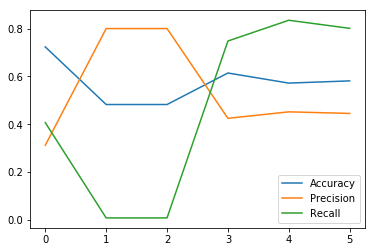

In [365]:
import matplotlib.pyplot as plt

plt.plot(acc,label='Accuracy')
plt.plot(pr,label='Precision')
plt.plot(rc,label = 'Recall')
plt.legend()
plt.show()

# Steps in the algorithm

## 1. Get window 
## 2. Compute integral image
## 3. Compute features on top of integral image
## 3. Train Adaboost on features
#### Sequence of weak classifiers with single features that cumulatively generate a score for the data to be positive or negative class
Increase in number of weak classifiers does not improve the accuracy. High number of weak classifiers lead to overfitting as the dataset size used for training is small compared to the features in the data


In [397]:
model = Adaboost(4)
model.fit(X_new,y_train)

Iteration:  0
0.3948497854077253 34
Iteration:  1
0.0 124
Iteration:  2
0.9921568627450981 192
Iteration:  3
1.0 130


In [398]:
y_pred = model.classify(X_test_new)
accuracy = (np.mean(np.abs(y_test-y_pred)))
print('Accuracy of the model: ', accuracy)
precision = np.sum(np.where((y_test==y_pred) & (y_pred==1),1,0))/np.sum(y_pred)
print('Precision: ' ,precision)
recall = np.sum(np.where((y_test==y_pred) & (y_test==1),1,0))/np.sum(y_test)
print('Recall: ' ,recall)

Accuracy of the model:  0.4825102880658436
Precision:  0.8
Recall:  0.00847457627118644


In [454]:
import cv2
def detect_faces(img):
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    w,l = img_gray.shape
    stride = 6
    faces = []
    W = (w-19)//stride
    L = (l-19)//stride
    print(W,L)
    for i in range(W):
        for j in range(L):
            
            ii = integral_image(img_gray[i*stride:i*stride+19,j*stride:j*stride+19])
            features = extract_features_int(ii)
            features = np.expand_dims(features,axis=0)
            features = min_max_scaler.transform(features)
            features = selector.transform(features)
            if model.classify(features) == 1:
                faces.append([i*stride,j*stride])
                
    
    for x,y, in faces:
        
        img = cv2.rectangle(cv2.UMat(img), (x, y), (x+19, y+19), (255,0,0), 2)
    
    plt.imshow(img.get())
    plt.show()     

13 13


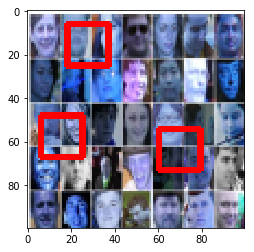

In [455]:
image = cv2.imread('C:\\Users\\user\\Pictures\\people.jpeg')
image = cv2.resize(image, (image.shape[0]//3,image.shape[1]//3), interpolation = cv2.INTER_AREA)
detect_faces(image[:100,:100])